## Задание 4.
Рассмотрим датасет по предсказанию года создания песни по числовым признакам.
Информацию о датасете можно найти здесь: 
- https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD#
- http://labrosa.ee.columbia.edu/millionsong
- https://en.wikipedia.org/wiki/Timbre

**Ссылка**: https://www.kaggle.com/t/506c3b7cd9c24937ae8fb2f50fedf5dd

Мы используем поднабор этого датасета. Пожалуйста, не используйте исходный датасет для читинга, за это получите 0 за ВООБЩЕ всю домашку. Это задание организовано с помощью соревнования на kaggle.
Попробуйте обучить нейронную сеть (используя линейные и другие слои, возможную нормализацию и активации). Можете использовать любые методы предобработки данных и фокусы, кроме ансамблирования и использования сторонних источников ДАННЫХ.
- Задание обязательно, базовое максимальное число баллов - 6. 
- Топ 25% получат +3 балла, топ 50 +2 балла, топ 75 +1 балл.
- Решение должно быть уникальным, необходимо предоставить код и описание решения. Если использованы внешние источники (туториалы, статьи и т.п.), необходимо предоставить ссылки.
- Обучите модель, используя ваш кастомный оптимизатор. Это даст еще 1 балл. Покажите, изменилось ли что-то.
- При решении задачи можно использовать любые встренные в torch модули (nn, optim, transforms, etc)
- Можно использовать numpy, sklearn, pandas ТОЛЬКО для предобработки и постобработки решения (сборки сабмишена). Для самой модели можно использовать только torch.
- При переобучении можно добавить dropout, batchnorm итд. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [34]:
X_train = pd.read_csv('../data/songs/train_x.csv', index_col=0)
y_train = pd.read_csv('../data/songs/train_y.csv', index_col=0)
X_test = pd.read_csv('../data/songs/test_x.csv')
X_test = X_test.set_index('id')

display(X_train.head())
display(y_train.head())

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
133081,37.47518,-14.34414,40.54872,-9.10171,16.77175,-17.77113,-16.50156,-4.09543,2.49723,-0.46428,...,104.03557,-115.62803,-13.79660,31.60436,28.95927,-25.93164,67.64670,-25.76691,-81.90373,-61.48682
111484,48.17393,-7.02208,-30.36086,-2.41924,2.15406,-8.44502,-1.68191,-8.71434,-7.83802,-5.58019,...,11.58664,24.58950,-36.95682,0.73922,-0.06330,53.75838,-81.05330,8.42811,12.08694,-1.91676
448402,36.58141,26.03203,-4.92774,35.71620,8.53080,3.73167,-7.98443,-7.43976,-1.69797,10.75028,...,23.61190,-366.07968,-62.38201,113.48188,4.72741,181.64459,-134.46216,8.50795,94.15573,-8.47276
254414,41.15615,-17.77029,-32.30961,-21.03778,12.80330,-13.48031,-3.14951,-7.62647,-4.48901,-4.29075,...,25.11398,-79.64532,-77.08169,38.88094,28.52025,24.17783,-86.62542,-1.19418,-74.73449,-17.28130
272580,40.54855,78.77563,-23.29877,98.60192,-30.11496,26.94220,-8.87771,-3.23280,-1.04841,31.69655,...,-9.89388,-252.61021,118.93768,-155.87390,51.85666,-365.15815,59.34936,52.47311,99.00695,-10.18840


,year
133081,2001
111484,2006
448402,1989
254414,1997
272580,2001


Суть задачи - дано численное представление песни, необходимо предсказать год, в котором выпущен данный трек (регрессия)

### 4.1. Baseline

1. Обучение на всех признаках
2. Без препроцессинга (только стандартизация)

#### 4.1.1 EDA

In [35]:
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_train: {X_test.shape}")

X_train: (14000, 90)
y_train: (14000, 1)
X_train: (6000, 90)


In [36]:
print(f"missings in X_train: {X_train.isna().sum().sum()}")
print(f"missings in X_test: {X_test.isna().sum().sum()}")

missings in X_train: 0
missings in X_test: 0


P.S. Проверяю количество пропусков в X_test, т.к. возможны ситуации, когда в тренировочной выборке нет пропусков, но это не гарантия того, что они не встретятся в тесте :)

In [37]:
display(X_train.describe().T.head(10))

,count,mean,std,min,25%,50%,75%,max
0,14000.0,43.394558,6.074562,7.19989,39.970260,44.282770,47.843418,57.40863
1,14000.0,1.540279,51.578894,-302.03190,-25.603507,8.800720,36.610743,240.61701
2,14000.0,8.378243,35.742553,-257.52560,-11.773080,10.226865,29.596557,318.86896
3,14000.0,1.315349,16.622971,-120.72315,-8.490435,-0.582025,9.035892,143.84160
4,14000.0,-6.476035,22.823521,-142.16068,-20.716735,-5.808040,7.858092,142.30548
5,14000.0,-9.503415,12.926176,-60.19862,-18.524397,-11.254920,-2.198952,68.30009
6,14000.0,-2.243164,14.700348,-100.60255,-10.651808,-2.007255,6.725500,147.96526
7,14000.0,-1.660698,8.035388,-51.44382,-6.402985,-1.516640,3.111740,52.33112
8,14000.0,3.543946,10.629817,-75.53955,-2.573275,3.658655,9.935210,78.14944
9,14000.0,1.892996,6.602191,-31.34416,-2.446435,1.763500,6.245860,36.59618


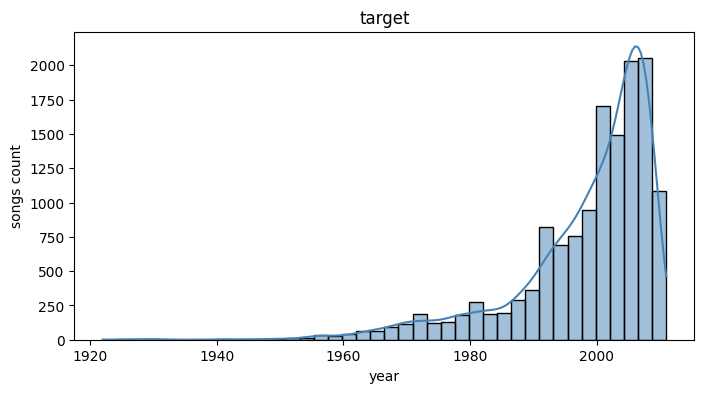

In [38]:
plt.figure(figsize=(8,4))
sns.histplot(y_train['year'], bins=40, kde=True, color='steelblue')
plt.title("target")
plt.xlabel("year")
plt.ylabel("songs count")
plt.show()

Тяжелый левый хвост, в основном все треки сосредеточены в период с конца 80х 

In [39]:
print("Минимальный год:", y_train['year'].min())
print("Максимальный год:", y_train['year'].max())

Минимальный год: 1922
Максимальный год: 2011


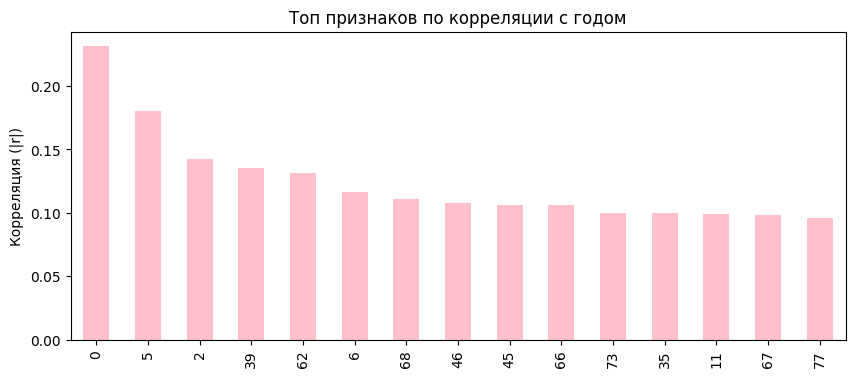

In [40]:
# Корреляция признаков с таргетом
corrs = X_train.corrwith(y_train['year'])
plt.figure(figsize=(10,4))
corrs.abs().sort_values(ascending=False).head(15).plot(kind='bar', color='pink')
plt.title("Топ признаков по корреляции с годом")
plt.ylabel("Корреляция (|r|)")
plt.show()

In [41]:
# Корреляция признаков друг с другом
corr_matrix = X_train.corr().abs()
np.fill_diagonal(corr_matrix.values, np.nan)
corr_pairs = (
    corr_matrix.unstack()
    .dropna()
    .sort_values(ascending=False)
    .reset_index()
)
corr_pairs.columns = ['feature_1', 'feature_2', 'correlation']
corr_pairs['pair'] = corr_pairs.apply(lambda x: tuple(sorted([x['feature_1'], x['feature_2']])), axis=1)
corr_pairs = corr_pairs.drop_duplicates('pair').drop(columns='pair')

top_corr = corr_pairs.head(10)
top_corr

# Видно, что есть довольно коррелирующие признаки (исключу их в дальнейшем)

,feature_1,feature_2,correlation
0,22,17,0.867229
2,19,21,0.865578
4,15,22,0.836375
6,17,15,0.816798
8,19,15,0.727138
10,22,21,0.721803
12,17,21,0.719773
14,22,19,0.711810
16,21,15,0.704172
18,57,59,0.702409


In [47]:
variances = X_train.var().sort_values()

# самые низкодисперсные фичи
low_var = variances[variances < 1e-1]
low_var.head(20)

Series([], dtype: float64)

#### 4.1.2. Обучение модели

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

In [11]:
X_tr, X_val, y_tr, y_val = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

X_tr = torch.tensor(X_tr, dtype=torch.float32)
y_tr = torch.tensor(y_tr, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

In [12]:
class BaselineModel(nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        return self.model(x)

В качестве лосса беру HuberLoss (или SmoothL1Loss в торче) - гибрид между MSE и MAE. Использую именно его, т.к. он более устойчив к выбросам, но в то же время имеет более гладкий градиент.

Для оптимизатора - RMSprop (чтобы потом отдельно сравнить со своим оптмизатором Adam)

In [13]:
model = BaselineModel(input_dim=X_tr.shape[1])
criterion = nn.SmoothL1Loss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-2, alpha=0.9, eps=1e-8)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.7)

In [14]:
EPOCHS = 100
for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    preds = model(X_tr)
    loss = criterion(preds, y_tr)
    loss.backward()
    optimizer.step()
    scheduler.step()

    model.eval()
    with torch.no_grad():
        val_pred = model(X_val)
        val_loss = criterion(val_pred, y_val)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

Epoch 10/100 | Train Loss: 0.3409 | Val Loss: 0.2977
Epoch 20/100 | Train Loss: 0.2635 | Val Loss: 0.2662
Epoch 30/100 | Train Loss: 0.2682 | Val Loss: 0.2735
Epoch 40/100 | Train Loss: 0.2433 | Val Loss: 0.2627
Epoch 50/100 | Train Loss: 0.2238 | Val Loss: 0.2575
Epoch 60/100 | Train Loss: 0.2170 | Val Loss: 0.2626
Epoch 70/100 | Train Loss: 0.2059 | Val Loss: 0.2599
Epoch 80/100 | Train Loss: 0.1967 | Val Loss: 0.2716
Epoch 90/100 | Train Loss: 0.1889 | Val Loss: 0.2678
Epoch 100/100 | Train Loss: 0.1810 | Val Loss: 0.2709


In [15]:
model.eval()
with torch.no_grad():
    preds_scaled = model(X_val).numpy()
    preds_real = scaler_y.inverse_transform(preds_scaled)
    true_real = scaler_y.inverse_transform(y_val.numpy())

mae = mean_absolute_error(true_real, preds_real)
print(f"MAE: {mae:.2f}")

MAE: 6.24


#### 4.1.3. Сбор сабмита

In [ ]:
# Заново обучаю (уже на всех данных)
scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

X = torch.tensor(X_scaled, dtype=torch.float32)
y = torch.tensor(y_scaled, dtype=torch.float32)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)


In [23]:
model = BaselineModel(input_dim=X.shape[1])
criterion = nn.SmoothL1Loss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-2, alpha=0.9, eps=1e-8)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.7)

In [ ]:
EPOCHS = 100
for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    preds = model(X)
    loss = criterion(preds, y)
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {loss.item():.4f}")

Epoch 10/100 | Train Loss: 0.2954
Epoch 20/100 | Train Loss: 0.2635
Epoch 30/100 | Train Loss: 0.2704
Epoch 40/100 | Train Loss: 0.2547
Epoch 50/100 | Train Loss: 0.2409
Epoch 60/100 | Train Loss: 0.2390
Epoch 70/100 | Train Loss: 0.2273
Epoch 80/100 | Train Loss: 0.2134
Epoch 90/100 | Train Loss: 0.2138
Epoch 100/100 | Train Loss: 0.2044


In [25]:
model.eval()
with torch.no_grad():
    preds_scaled = model(X_test_t).numpy()
    preds_real = scaler_y.inverse_transform(preds_scaled)

In [30]:
submission = pd.DataFrame({
    'id': X_test.index,
    'year': preds_real.flatten().astype(int)
})

submission.to_csv('submission.csv', index=False)

public score: 87.56118

### 4.2 Решение с препроцессингом

In [100]:
# Убираем линейно-зависимые фичи
corr_matrix = X_train.corr().abs()
threshold = 0.7

to_drop = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > threshold:
            colname = corr_matrix.columns[j]
            to_drop.add(colname)

print(f"{len(to_drop)} коррелирующих признаков (corr > {threshold}).")

X_train_reduced = X_train.drop(columns=list(to_drop))
X_test_reduced = X_test.drop(columns=[c for c in to_drop if c in X_test.columns])


5 коррелирующих признаков (corr > 0.7).


In [101]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_reduced)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

In [102]:
X_tr, X_val, y_tr, y_val = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

X_tr = torch.tensor(X_tr, dtype=torch.float32)
y_tr = torch.tensor(y_tr, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

In [ ]:
class Model(nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.4),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            
           nn.Linear(32, 1)
        )

        for layer in self.model:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, nonlinearity='leaky_relu')
                nn.init.constant_(layer.bias, 0.0)

    def forward(self, x):
        return self.model(x)

In [121]:
model = Model(input_dim=X_tr.shape[1])
criterion = nn.SmoothL1Loss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-2, alpha=0.9, eps=1e-8)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.7)

In [122]:
X_tr.shape

torch.Size([11200, 85])

In [125]:
EPOCHS = 200
for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    preds = model(X_tr)
    loss = criterion(preds, y_tr)
    loss.backward()
    optimizer.step()
    scheduler.step()

    model.eval()
    with torch.no_grad():
        val_pred = model(X_val)
        val_loss = criterion(val_pred, y_val)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

Epoch 10/200 | Train Loss: 0.2369 | Val Loss: 0.2535
Epoch 20/200 | Train Loss: 0.2372 | Val Loss: 0.2533
Epoch 30/200 | Train Loss: 0.2335 | Val Loss: 0.2533
Epoch 40/200 | Train Loss: 0.2327 | Val Loss: 0.2533
Epoch 50/200 | Train Loss: 0.2356 | Val Loss: 0.2532
Epoch 60/200 | Train Loss: 0.2336 | Val Loss: 0.2536
Epoch 70/200 | Train Loss: 0.2355 | Val Loss: 0.2534
Epoch 80/200 | Train Loss: 0.2339 | Val Loss: 0.2534
Epoch 90/200 | Train Loss: 0.2325 | Val Loss: 0.2533
Epoch 100/200 | Train Loss: 0.2312 | Val Loss: 0.2535
Epoch 110/200 | Train Loss: 0.2308 | Val Loss: 0.2534
Epoch 120/200 | Train Loss: 0.2334 | Val Loss: 0.2534
Epoch 130/200 | Train Loss: 0.2311 | Val Loss: 0.2535
Epoch 140/200 | Train Loss: 0.2303 | Val Loss: 0.2536
Epoch 150/200 | Train Loss: 0.2326 | Val Loss: 0.2534
Epoch 160/200 | Train Loss: 0.2332 | Val Loss: 0.2535
Epoch 170/200 | Train Loss: 0.2341 | Val Loss: 0.2535
Epoch 180/200 | Train Loss: 0.2321 | Val Loss: 0.2534
Epoch 190/200 | Train Loss: 0.2330 | 

In [126]:
model.eval()
with torch.no_grad():
    preds_scaled = model(X_val).numpy()
    preds_real = scaler_y.inverse_transform(preds_scaled)
    true_real = scaler_y.inverse_transform(y_val.numpy())

mae = mean_absolute_error(true_real, preds_real)
print(f"MAE: {mae:.2f}")

MAE: 6.00


In [127]:
# Заново обучаю (уже на всех данных)
scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X_train_reduced)
X_test_scaled = scaler_x.transform(X_test_reduced)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

X = torch.tensor(X_scaled, dtype=torch.float32)
y = torch.tensor(y_scaled, dtype=torch.float32)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)


In [128]:
model = Model(input_dim=X.shape[1])
criterion = nn.SmoothL1Loss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-2, alpha=0.9, eps=1e-8)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.7)

In [130]:
EPOCHS = 200
for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    preds = model(X)
    loss = criterion(preds, y)
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {loss.item():.4f}")

Epoch 10/200 | Train Loss: 0.2434
Epoch 20/200 | Train Loss: 0.2416
Epoch 30/200 | Train Loss: 0.2408
Epoch 40/200 | Train Loss: 0.2385
Epoch 50/200 | Train Loss: 0.2407
Epoch 60/200 | Train Loss: 0.2405
Epoch 70/200 | Train Loss: 0.2377
Epoch 80/200 | Train Loss: 0.2396
Epoch 90/200 | Train Loss: 0.2371
Epoch 100/200 | Train Loss: 0.2377
Epoch 110/200 | Train Loss: 0.2381
Epoch 120/200 | Train Loss: 0.2408
Epoch 130/200 | Train Loss: 0.2404
Epoch 140/200 | Train Loss: 0.2378
Epoch 150/200 | Train Loss: 0.2383
Epoch 160/200 | Train Loss: 0.2373
Epoch 170/200 | Train Loss: 0.2407
Epoch 180/200 | Train Loss: 0.2384
Epoch 190/200 | Train Loss: 0.2375
Epoch 200/200 | Train Loss: 0.2382


In [131]:
model.eval()
with torch.no_grad():
    preds_scaled = model(X_test_t).numpy()
    preds_real = scaler_y.inverse_transform(preds_scaled)

In [132]:
submission = pd.DataFrame({
    'id': X_test.index,
    'year': preds_real.flatten().astype(int)
})

submission.to_csv('submission.csv', index=False)

public score: 84.84